2. (Deep) CNNs for Image Colorization

(a) This assignment uses a convolutional neural network for image colorization which
turns a grayscale image to a colored image.5 By converting an image to grayscale,
we loose color information, so converting a grayscale image back to a colored
version is not an easy job. We will use the CIFAR-10 dataset. Downolad the
dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data/cifar-10', train=True, download=True, transform=transform)
# trainset = torchvision.datasets.CIFAR10(root='../data/cifar-10', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data/cifar-10', train=False, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='../data/cifar-10', train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


(b) From the train and test dataset, extract the class birds. We will focus on this
class, which has 6000 members.

In [3]:
train_bird, test_bird = [], []
for i in range(len(trainset)):
    label_i = trainset[i][-1]
    if label_i==2:
        train_bird.append(trainset[i])

for i in range(len(testset)):
    label_i = testset[i][-1]
    if label_i==2:
        test_bird.append(testset[i])

In [4]:
train_bird_loader = torch.utils.data.DataLoader(train_bird, batch_size=batch_size, shuffle=True, num_workers=2)
test_bird_loader = torch.utils.data.DataLoader(test_bird, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(train_bird), len(test_bird))

5000 1000


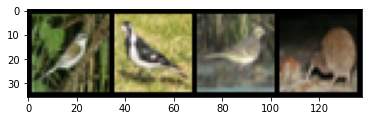

 bird  bird  bird  bird


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_bird_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

(c) Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels
randomly. It is strongly recommended that you choose a large number or all of
the pixels. You will have between P = 614400 and P = 6144000 pixels. Each
pixel is an RGB vector with three elements.

In [6]:
from tqdm import tqdm
# print(train_bird[0][0].shape)
# we choose all of the pixels
pixels = []
for i in tqdm(range(len(train_bird))):
    item = train_bird[i][0]
    for j in range(item.shape[1]):
        for k in range(item.shape[2]):
            pixels.append([item[0][j][k], item[1][j][k], item[2][j][k]])

for i in tqdm(range(len(test_bird))):
    item = test_bird[i][0]
    for j in range(item.shape[1]):
        for k in range(item.shape[2]):
            pixels.append([item[0][j][k], item[1][j][k], item[2][j][k]])

pixels = np.array(pixels)
bird_origin = np.reshape(pixels, (6000,32,32,3))
len(pixels)

100%|██████████| 1000/1000 [00:31<00:00, 31.71it/s]


6144000

In [7]:
pixels

array([[0.6431373 , 0.80784315, 0.32941177],
       [0.4117647 , 0.54901963, 0.23921569],
       [0.4627451 , 0.5803922 , 0.39607844],
       ...,
       [0.6117647 , 0.7019608 , 0.37254903],
       [0.61960787, 0.7058824 , 0.38431373],
       [0.6156863 , 0.7019608 , 0.38431373]], dtype=float32)

(d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters
will be your main colors. Convert the colored images to k-color images by converting each pixel’s value to the closest main color in terms of Euclidean distance.
These are the outputs of your network, whose each pixel falls in one of those k
classes.6

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(pixels) 
cluscenter = kmeans.cluster_centers_
cluscenter

array([[0.42750385, 0.42604566, 0.3240611 ],
       [0.8095992 , 0.83025324, 0.8283291 ],
       [0.61205447, 0.60934705, 0.5313681 ],
       [0.19282097, 0.19605693, 0.15123418]], dtype=float32)

In [9]:
#  Navy = (0,0,128), Red =( 230, 25, 75), Mint = (170, 255, 195), and White = (255, 255, 255).

recommend = np.array([[0,0,128], [230, 25, 75], [170, 255, 195], [255, 255, 255]])/255
kmeans.cluster_centers_ = np.array(recommend, dtype=np.float32)
kmeans.cluster_centers_
color_id = kmeans.predict(pixels)
pixels_5_color = []
for i in range(len(pixels)):
    pixels_5_color.append(kmeans.cluster_centers_[color_id[i]])

bird_5_color = np.reshape(pixels_5_color, (6000,32,32,3))

In [10]:
bird_5_color.shape

(6000, 32, 32, 3)

(e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images
from the original 32 × 32 × 3 images. The grayscale images are inputs of your
network.

In [11]:
from skimage.color import rgb2gray
gray_birds = np.expand_dims(rgb2gray(bird_origin), axis=-1)

In [12]:
gray_birds.shape

(6000, 32, 32, 1)

In [13]:
bird_origin.shape

(6000, 32, 32, 3)

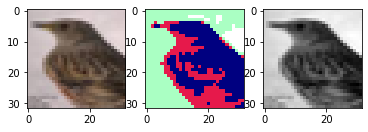

In [14]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(bird_origin[2])
axes[1].imshow(bird_5_color[2])
axes[2].imshow(np.stack((gray_birds[2, :, :, 0], ) , axis=-1), cmap='gray')
plt.show()

(f) Set up a deep convolutional neural network with two convolution layers (or more)
and two (or more) MLP layers. Use 5 × 5 filters and a softmax output layer.
Determine the number of filters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. Use a classification scheme, which
means your output must determine one of the k = 4 color classes for each pixel in
your grayscale image. Your input is a grayscale version of an image (32 × 32 × 1)
and the output is 32 × 32 × 4. The output assigns one of the k = 4 colors to
each of the 32 × 32 pixels; therefore, each of the pixels is classified into one of the
classes [1 0 0 0], [0 1 0 0], [0 0 1 0], [0 0 0 1]. After each pixel is classified into one
of the main colors, the RGB code of that color can be assigned to the pixel. For
example, if the third main color 7
is [255 255 255] and pixel (32,32) of an image
has the one-hot encoded class [0 0 1 0], i.e it was classified as the third color, the
(32,32) place in the output can be associated with [255 255 255]. The size of the
output of the convolutional part, c1 × c2 depends on the size of the convolutional
layers you choose and is a feature map, which is a matrix. That matrix must be
flattened or reshaped, i.e. must be turned into a vector of size c1c2 ×1, before it is
fed to the MLP part. Choose the number of neurons in the first layer of the MLP
(and any other hidden layers, if you are willing to have more than one hidden
layer) yourself, but the last layer must have 32 × 32 × 4 = 4096 neurons, each of
which represents a pixel being in one of the k = 4 classes. Add a softmax layer8
which will choose the highest value out of its k = 4 inputs for each of the 1024
pixels; therefore, the output of the MLP has to be reshaped into a 32 × 32 × 4
matrix, and to get the colored image, the RGB vector of each of the k = 4 classes
has to be converted to the RGB vector, so an output image will be 32 × 32 × 3.
Train at least for 5 epochs (30 epochs is strongly recommended). Plot training,
(validation), and test errors in each epoch. Report the train and test errors and
visually compare the artificially colored versions of the first 10 images in the test
set with the original images.9

In [15]:
import torch.nn.functional as F
import torch

gray_birds_ = gray_birds.transpose(0,3,1,2)
# print(color_id)
color_onehot = F.one_hot(torch.from_numpy(color_id).to(torch.int64), num_classes=4)
color_onehot.shape
color_onehot = color_onehot.numpy()
# print(color_onehot.shape)
# print(color_onehot[:10])
color_onehot = color_onehot.reshape((6000, 32, 32, 4))

train_cnn = [(torch.from_numpy(gray_birds_[i]), torch.from_numpy(color_onehot[i]).to(torch.float)) for i in range(5000)]
test_cnn = [(torch.from_numpy(gray_birds_[i]), torch.from_numpy(color_onehot[i]).to(torch.float)) for i in range(5000, 6000)]

train_cnn_loader = torch.utils.data.DataLoader(train_cnn, batch_size=512, shuffle=True, num_workers=4)
test_cnn_loader = torch.utils.data.DataLoader(test_cnn, batch_size=512, shuffle=False, num_workers=4)

In [20]:
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding='same')
        # init.xavier_uniform_(self.conv1.weight)
        # init.constant_(self.conv1.bias, 0.1)
        self.conv2 = nn.Conv2d(32, 32, 5, padding='same')
        self.conv3 = nn.Conv2d(32, 64, 5, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 5, padding='same')
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4096, 4096*2)
        self.fc2 = nn.Linear(4096*2, 4096)

    def forward(self, x):
        # print('1', x.shape)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        # print('2', x.shape)
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout1(x)
        # print('3', x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print('4', x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        # print('5', x.shape)
        x = F.relu(self.fc2(x))
        # print('6', x.shape)
        x = torch.reshape(x,(x.shape[0], 32, 32, 4))
        x = F.softmax(x, dim=-1)
        # print('7', x.shape)
        return x

net = Net()

# criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [21]:
train_losses, test_losses = [], []

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_cnn_loader, 0):
        train_loss, test_loss = [], []
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        # break
        # print('output:', outputs, 'labels: ', labels)
        # print('output:', outputs.shape, 'labels: ', labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print(loss)
        # loss
        train_loss.append(loss.item())
        running_loss += loss.item()
        print('epoch:%d, step:%5d loss: %.3f' % (epoch + 1, i + 1, running_loss))
        running_loss = 0.0

        # net.eval()
        # for i, data in enumerate(test_cnn_loader, 0):
        #     inputs, labels = data
        #     outputs = net(inputs)
        #     loss = criterion(outputs, labels)
        #     test_loss.append(loss.item())
        # train_losses.append(np.average(train_loss))
        # test_losses.append(np.average(test_loss))

    net.eval()
    for i, data in enumerate(test_cnn_loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
    train_losses.append(np.average(train_loss))
    test_losses.append(np.average(test_loss))

print('Finished Training')

epoch:1, step:    1 loss: 27.726
epoch:1, step:    2 loss: 27.725
epoch:1, step:    3 loss: 27.724
epoch:1, step:    4 loss: 27.723
epoch:1, step:    5 loss: 27.722
epoch:1, step:    6 loss: 27.716
epoch:1, step:    7 loss: 27.714
epoch:1, step:    8 loss: 27.707
epoch:1, step:    9 loss: 27.697
epoch:1, step:   10 loss: 27.698
epoch:2, step:    1 loss: 27.696
epoch:2, step:    2 loss: 27.701
epoch:2, step:    3 loss: 27.687
epoch:2, step:    4 loss: 27.691
epoch:2, step:    5 loss: 27.678
epoch:2, step:    6 loss: 27.673
epoch:2, step:    7 loss: 27.672
epoch:2, step:    8 loss: 27.663
epoch:2, step:    9 loss: 27.675
epoch:2, step:   10 loss: 27.675
epoch:3, step:    1 loss: 27.644
epoch:3, step:    2 loss: 27.660
epoch:3, step:    3 loss: 27.648
epoch:3, step:    4 loss: 27.636
epoch:3, step:    5 loss: 27.617
epoch:3, step:    6 loss: 27.607
epoch:3, step:    7 loss: 27.610
epoch:3, step:    8 loss: 27.582
epoch:3, step:    9 loss: 27.577
epoch:3, step:   10 loss: 27.586
epoch:4, s

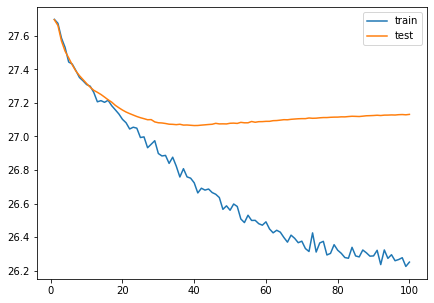

In [22]:
fig, axes = plt.subplots(figsize=(7, 5))
axes.plot(range(1, len(train_losses)+1), train_losses, label='train')
axes.plot(range(1, len(test_losses)+1), test_losses, label='test')
axes.legend()
plt.show()

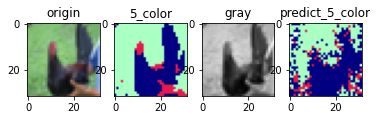

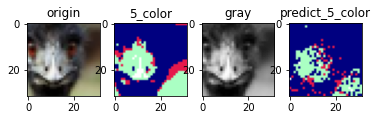

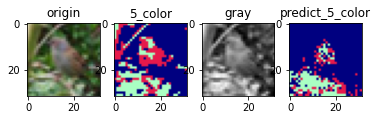

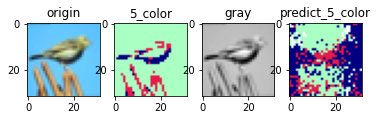

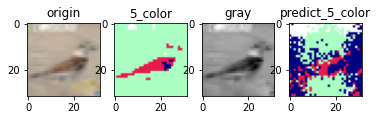

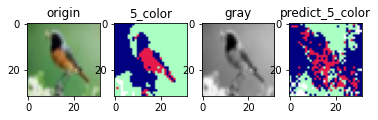

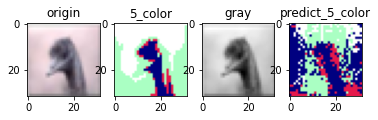

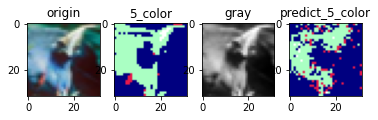

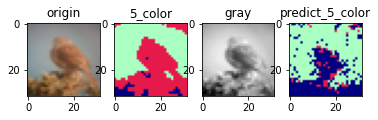

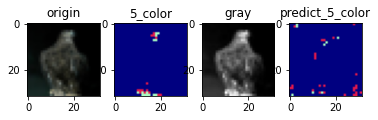

In [27]:
begin=0
for i in range(begin, begin+10):
    cnn_predict_y = net(test_cnn[i][0].unsqueeze(0)).detach().numpy()
    # print(cnn_predict_y.shape, cnn_predict_y[0][0][0])
    # print(test_cnn[i][0][0][0])
    
    cnn_predict_y = np.reshape(cnn_predict_y, (32, 32, 4))
    cnn_predict_y = np.argmax(cnn_predict_y, axis=-1)
    cnn_predict_y = kmeans.cluster_centers_[cnn_predict_y]

    
    fig, axes = plt.subplots(1, 4)
    axes[0].set_title('origin')
    axes[1].set_title('5_color')
    axes[2].set_title('gray')
    axes[3].set_title('predict_5_color')
    axes[0].imshow(bird_origin[i+5000])
    axes[1].imshow(bird_5_color[i+5000])
    axes[2].imshow(np.stack((gray_birds[i+5000, :, :, 0], ) , axis=-1), cmap='gray')
    axes[3].imshow(cnn_predict_y)
    # print(bird_5_color[i+5000][0][:4])
    # print(cnn_predict_y[0][:4])
    plt.show()